In [1]:
# importing libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
# importing data
df = pd.read_csv('data/processed_high_impact_outages.csv', parse_dates=['Start', 'Finish'])
df = df.replace({r"\r|\n": " "}, regex=True)
df.columns = df.columns.str.replace(r'[\r\n]', ' ', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
# df = df.drop(columns=['Status_Description_Market', 'Market_Notice_Code', 'Impact_Region'])

df = df[(df['Duration_Hours'] != 0) & (df['Region'] != 'VIC/ TAS') & (df['Unplanned?'] != 1)]
df = df.dropna()
df.head(5)

,Region,NSP,Start,Finish,Network Asset,Recall_Day_Hours,Recall_Night_Hours,Project Work?,Unplanned?,DNSP Aware?,Generator Aware?,Inter-Regional,Status_Description,Status_Code,Reason,Duration_Hours,Impact,file_name
0,NSW,Transgrid,2021-08-30 06:05:00,2021-09-01 12:00:00,Armidale - Dumaresq (8C) 330 kV Line,3.0,4.0,0,0,0,0,1,In Progress,PTP,Commissioning,52.8,<<UPDATED since the last notification>> A cre...,2021-08-30
1,QLD,Powerlink,2021-09-01 08:30:00,2021-09-01 12:00:00,Ross No.4 288/138/19 kV Transformer,1.0,0.0,0,0,1,0,0,Planned,MTLTP,Maintenance,3.5,This is a high impact outage because the recal...,2021-08-30
2,NSW,Transgrid,2021-09-04 06:00:00,2021-09-05 17:00:00,Liddell to Muswellbrook (83) 330 kV Line,4.0,4.0,0,0,1,0,1,Planned,MTLTP,Commissioning,36.0,A credible contingency event during this plann...,2021-08-30
3,SA,ElectraNet,2021-09-06 08:00:00,2021-09-12 08:15:00,Heywood - South East No.1 275 kV Line,159.0,159.0,0,0,0,0,1,Planned,SUBMIT,Commissioning,144.0,<<NEW since the last notification>> A credibl...,2021-08-30
4,QLD,Powerlink,2021-09-06 08:30:00,2021-09-10 16:00:00,Ross No.3 288/138/19 kV Transformer,4.0,6.0,0,0,1,0,0,Planned,MTLTP,Maintenance,103.2,This is a high impact outage because the recal...,2021-08-30


In [3]:
df['Region'].value_counts()

Region
VIC    9522
QLD    3753
SA     2452
NSW    1053
TAS     961
Name: count, dtype: int64

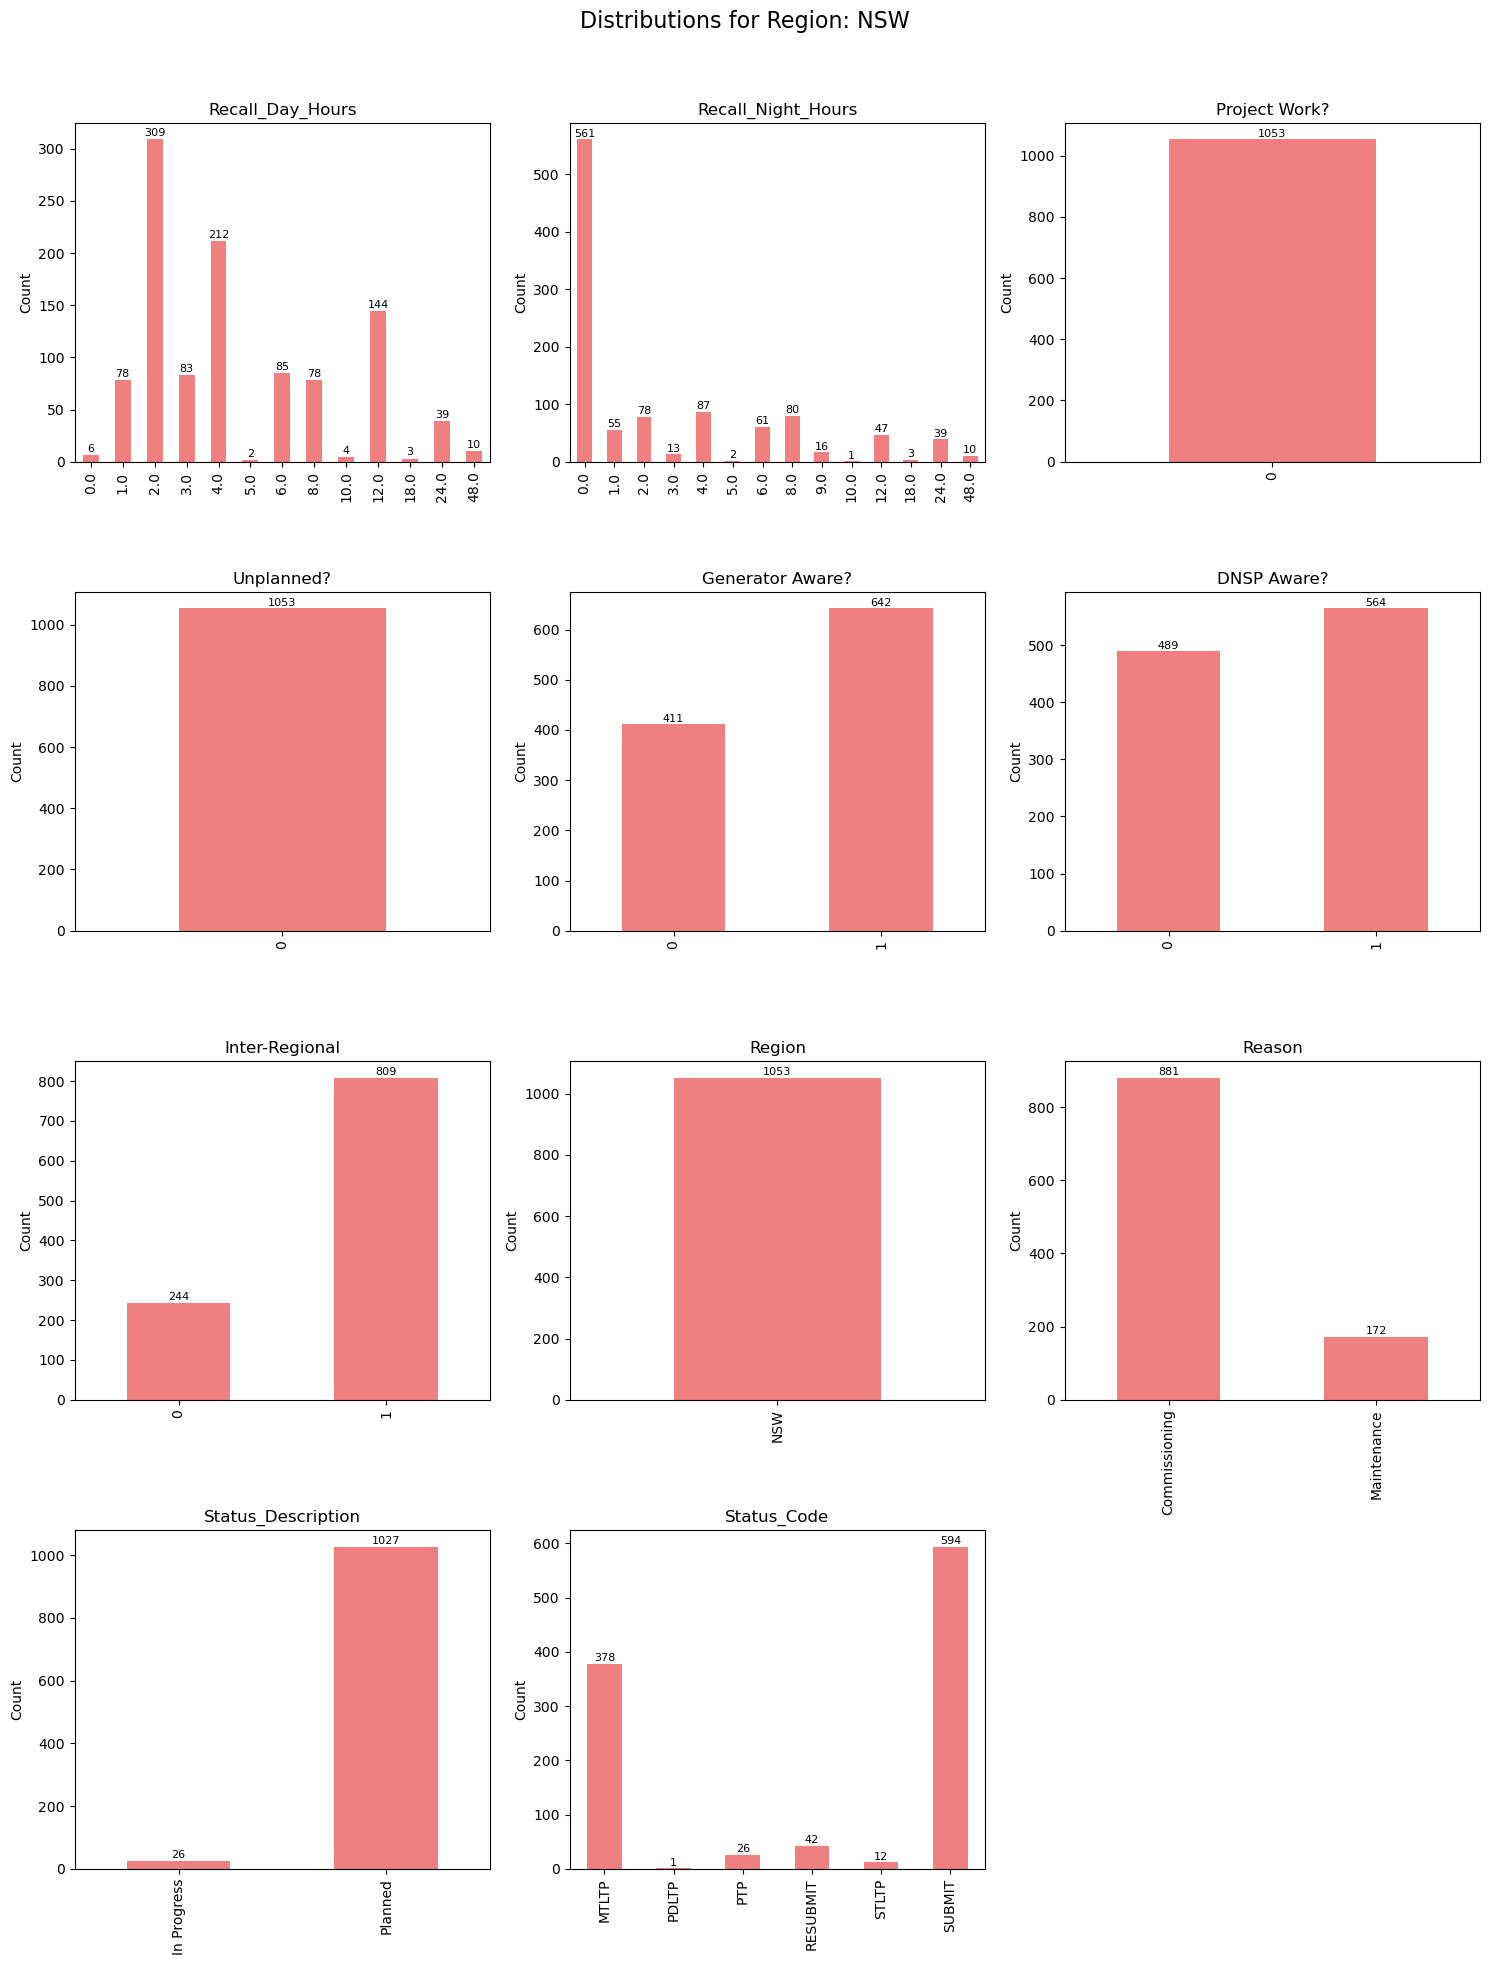

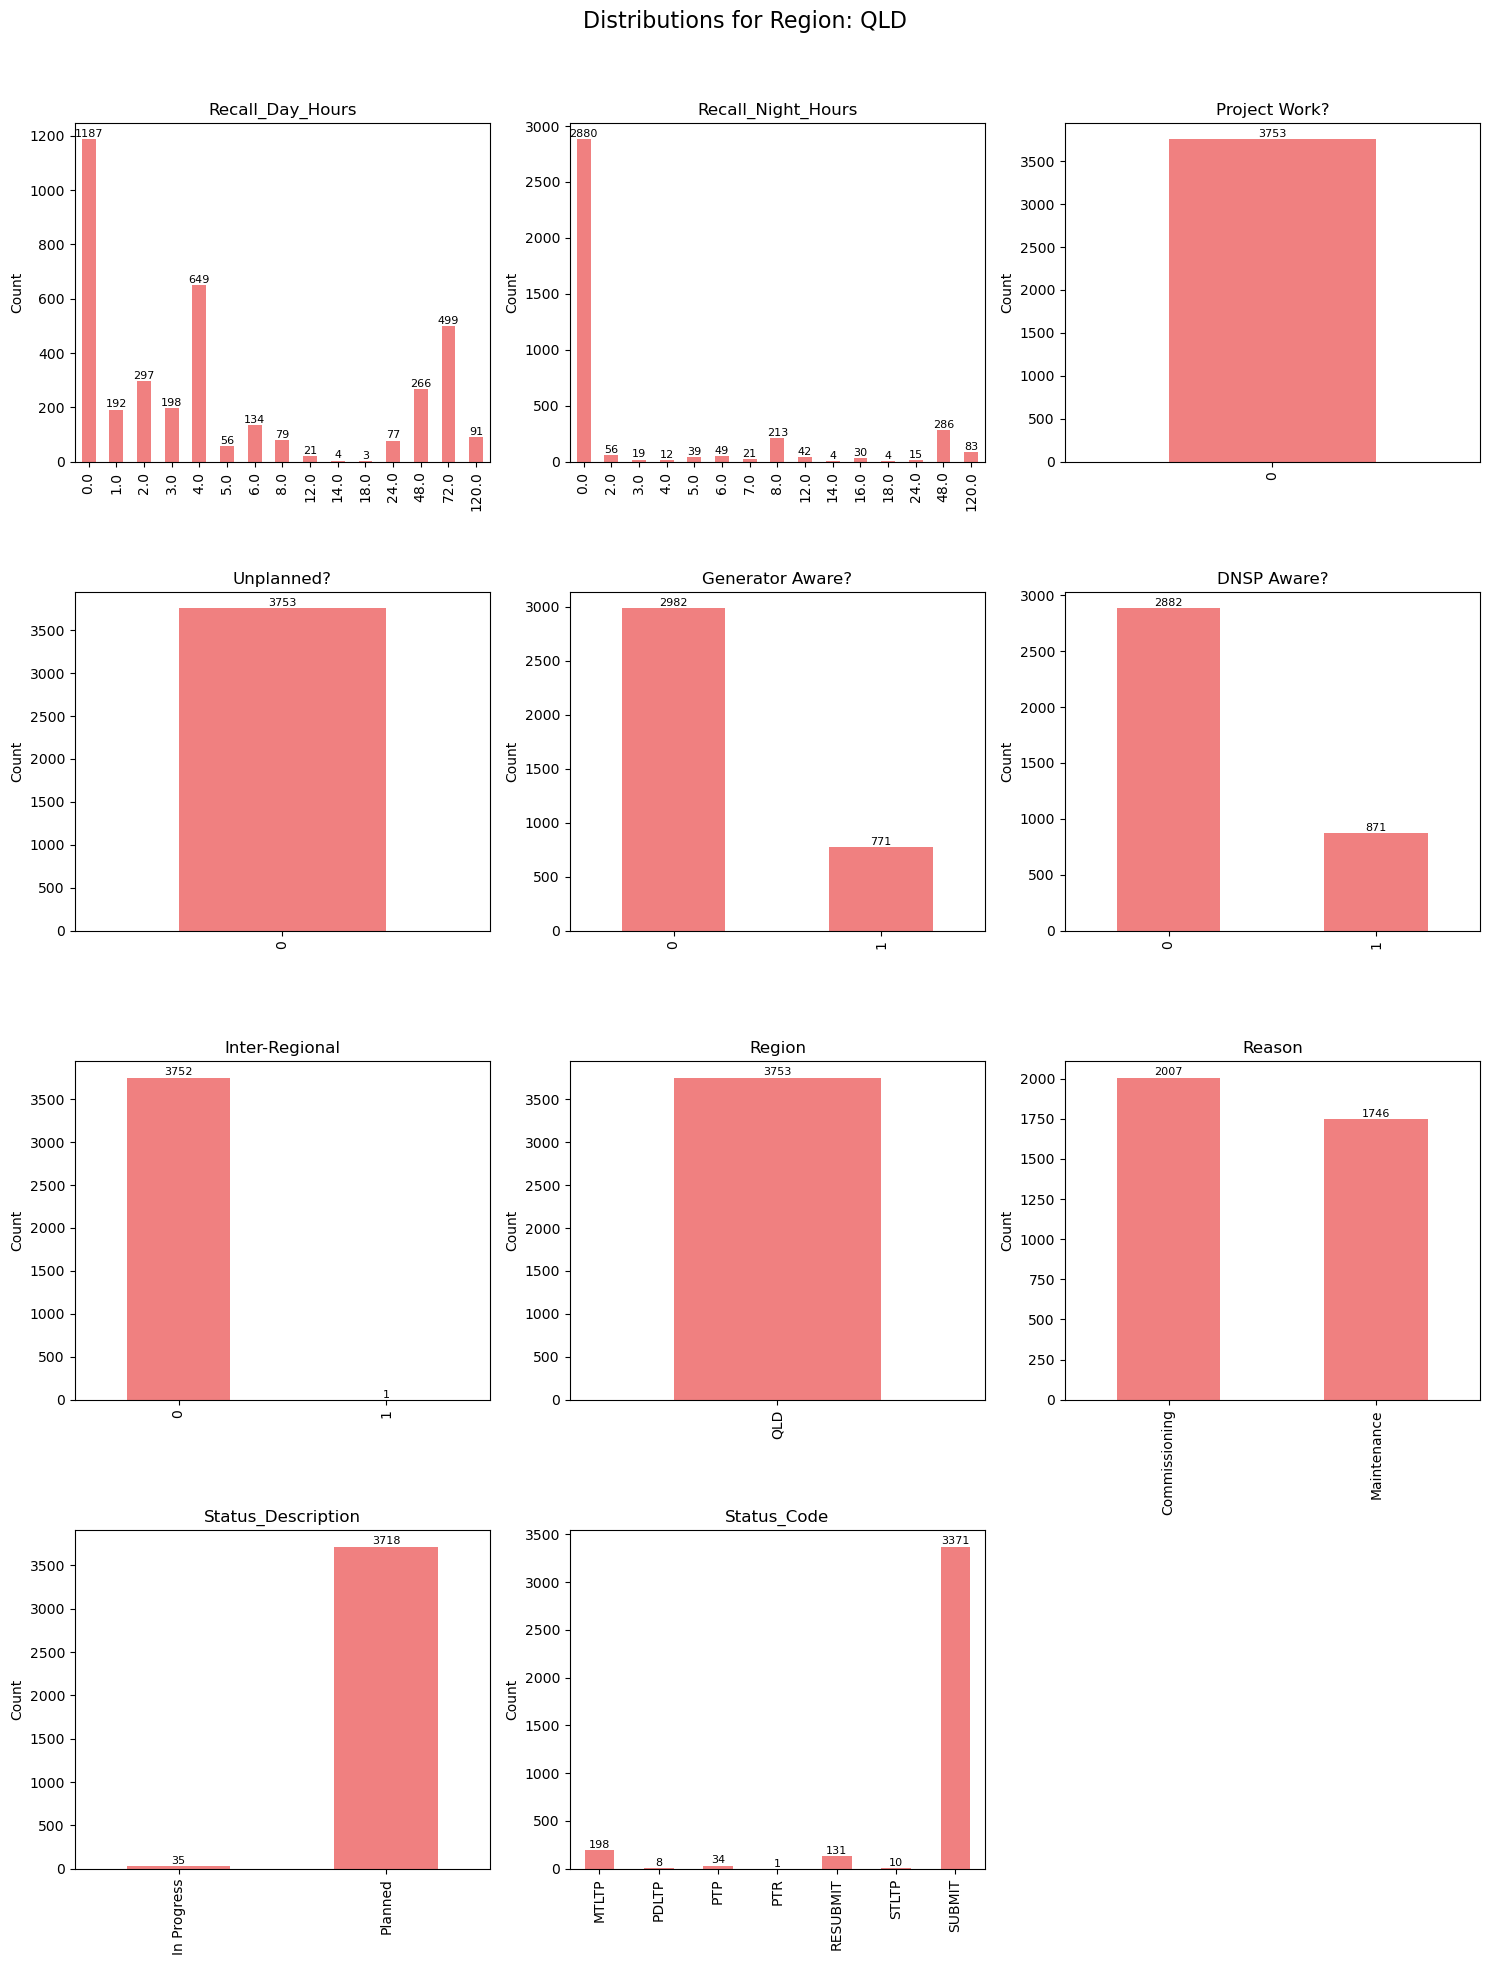

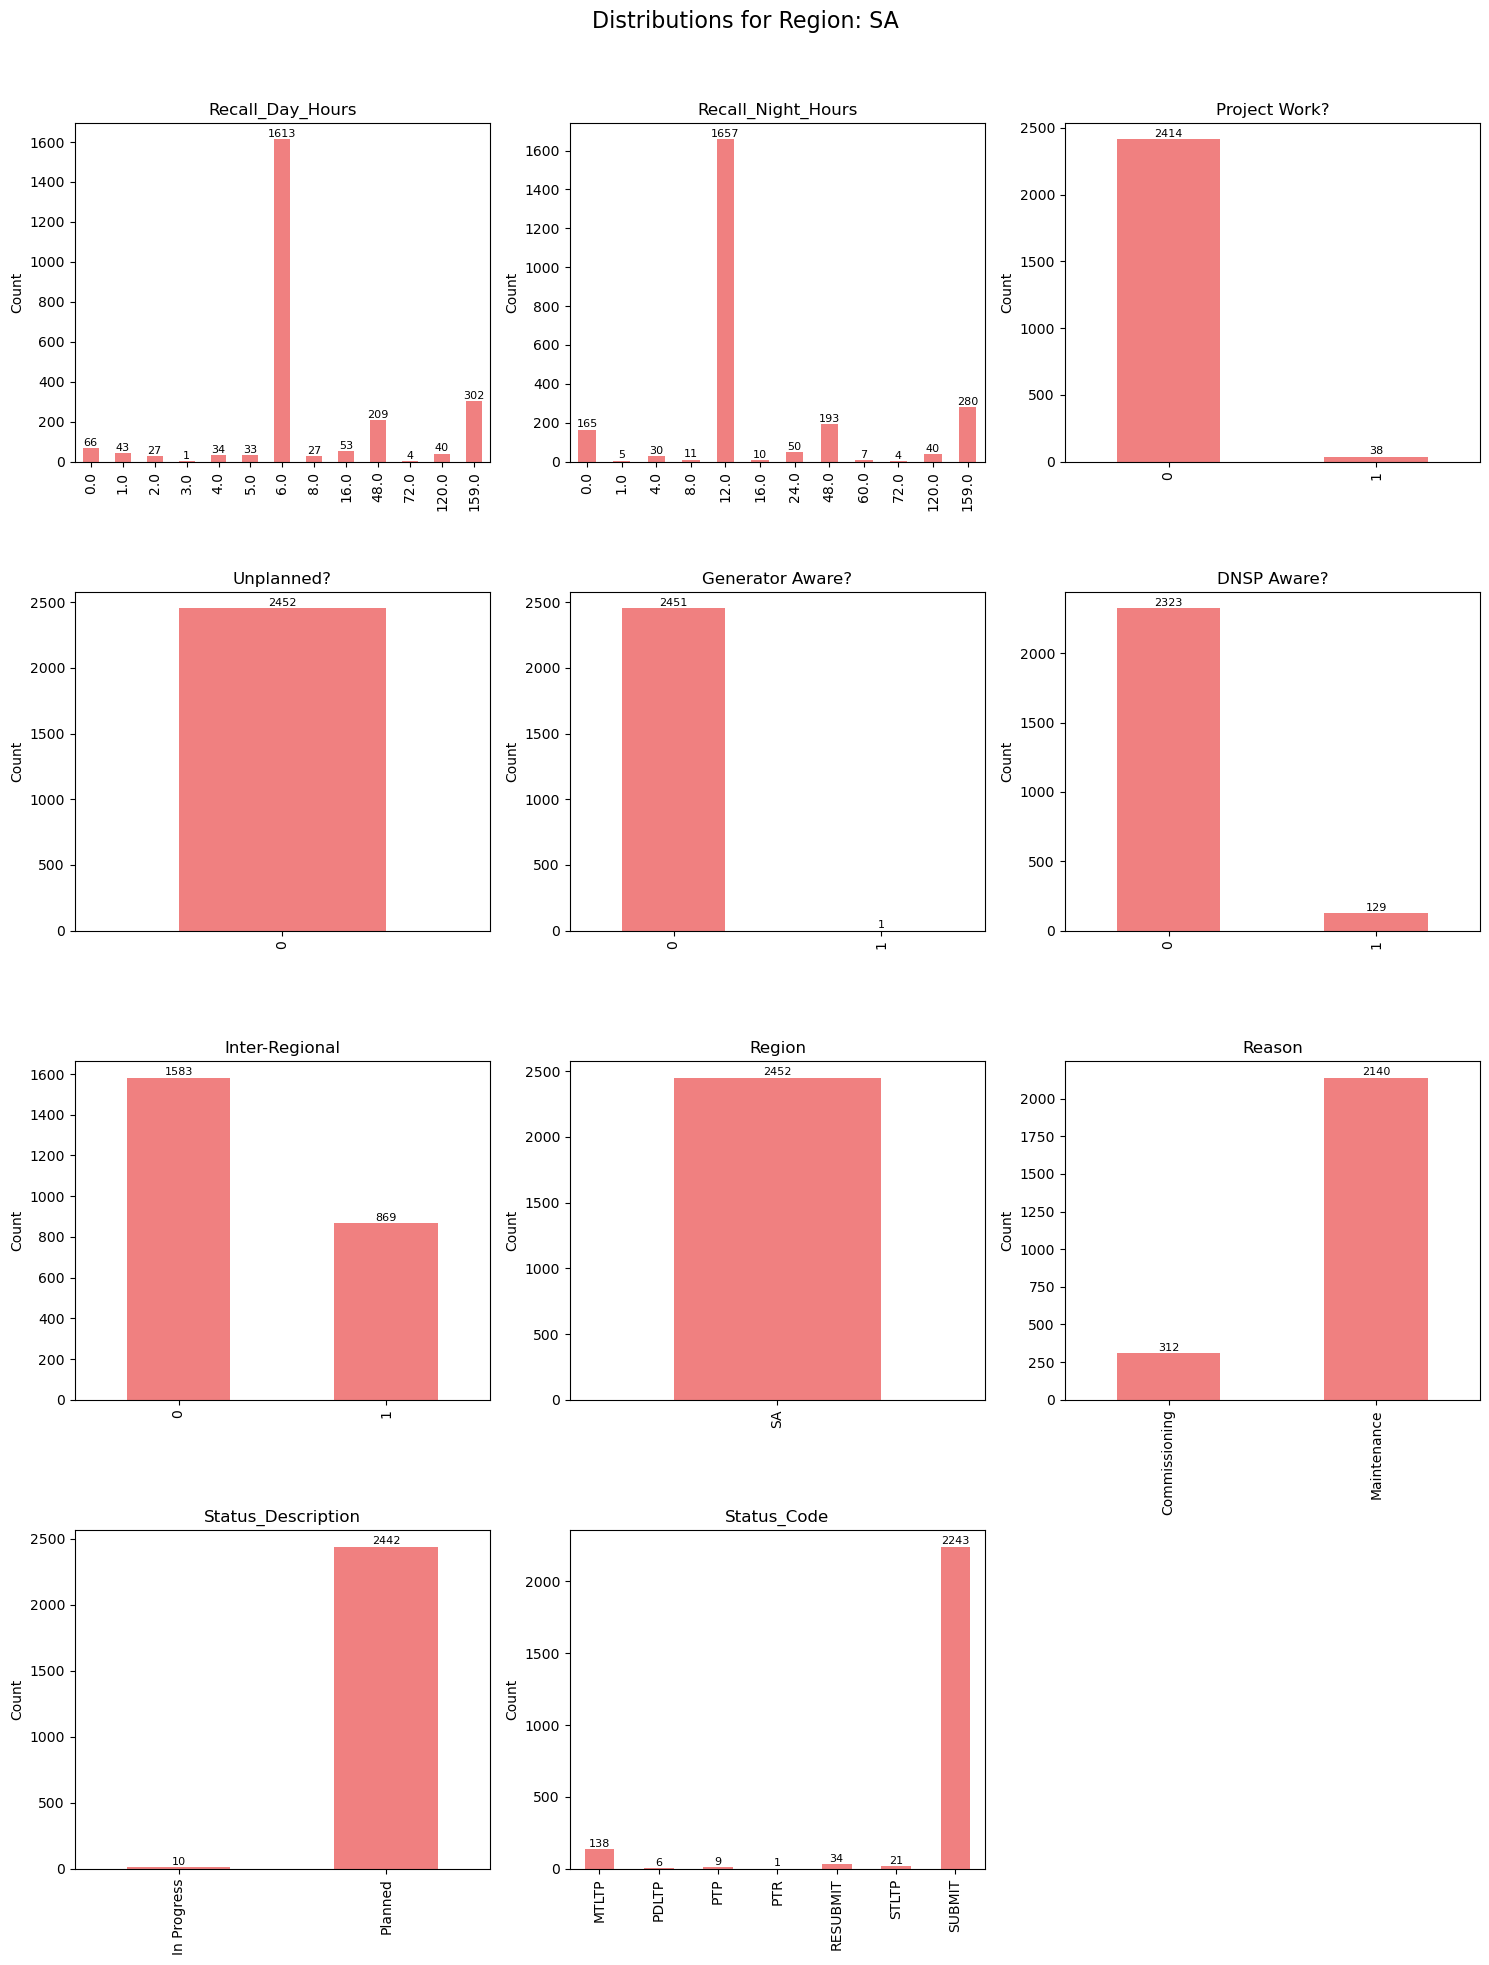

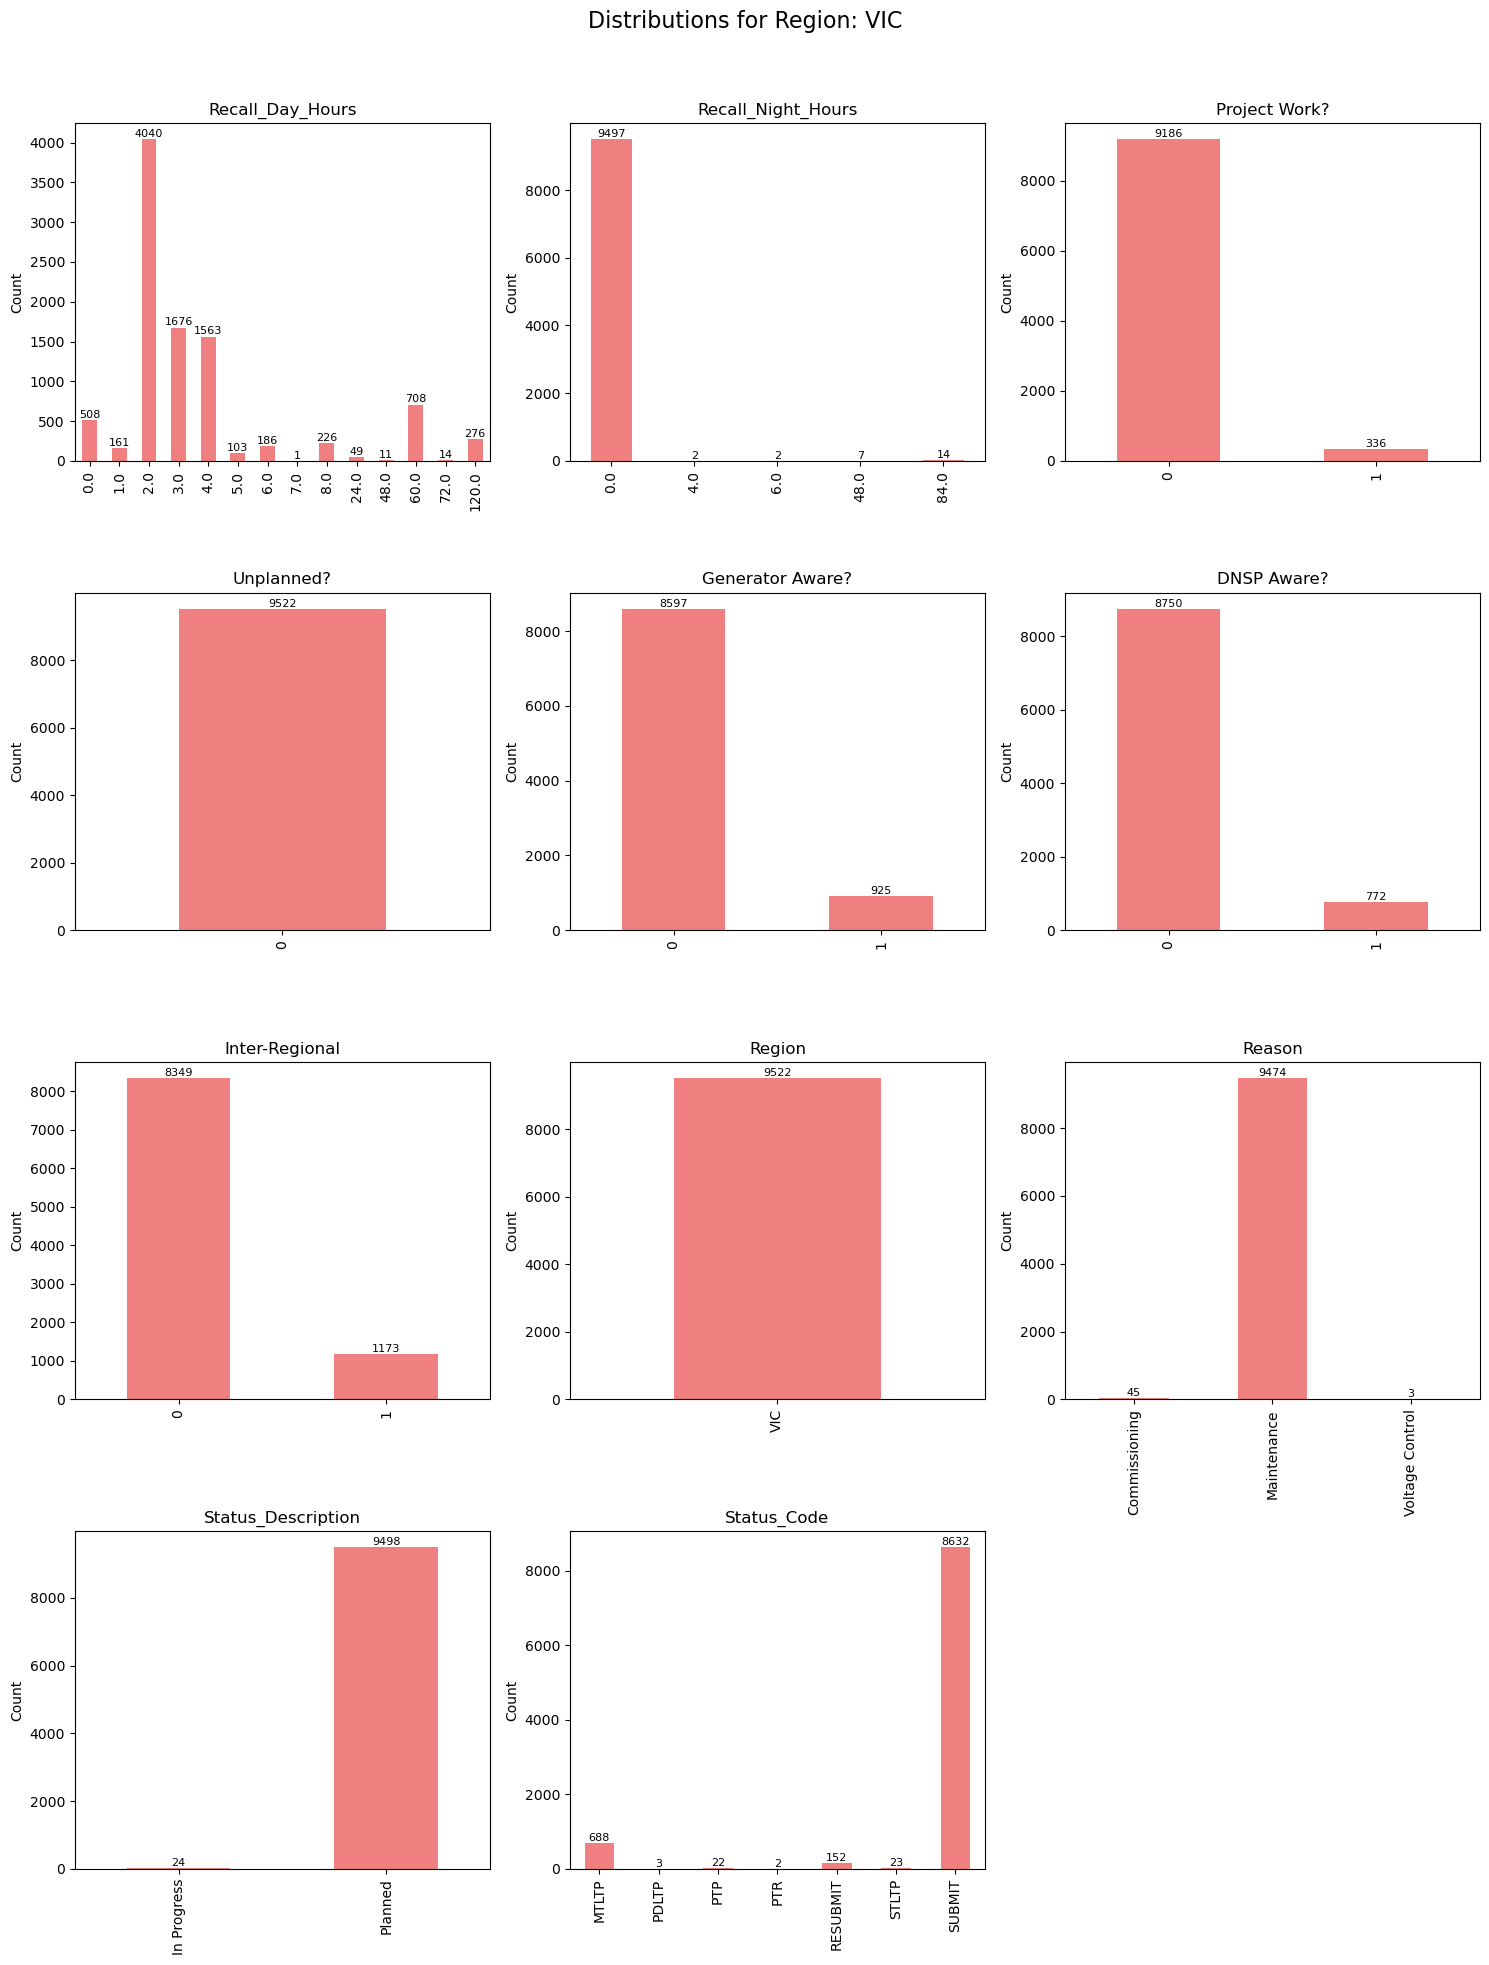

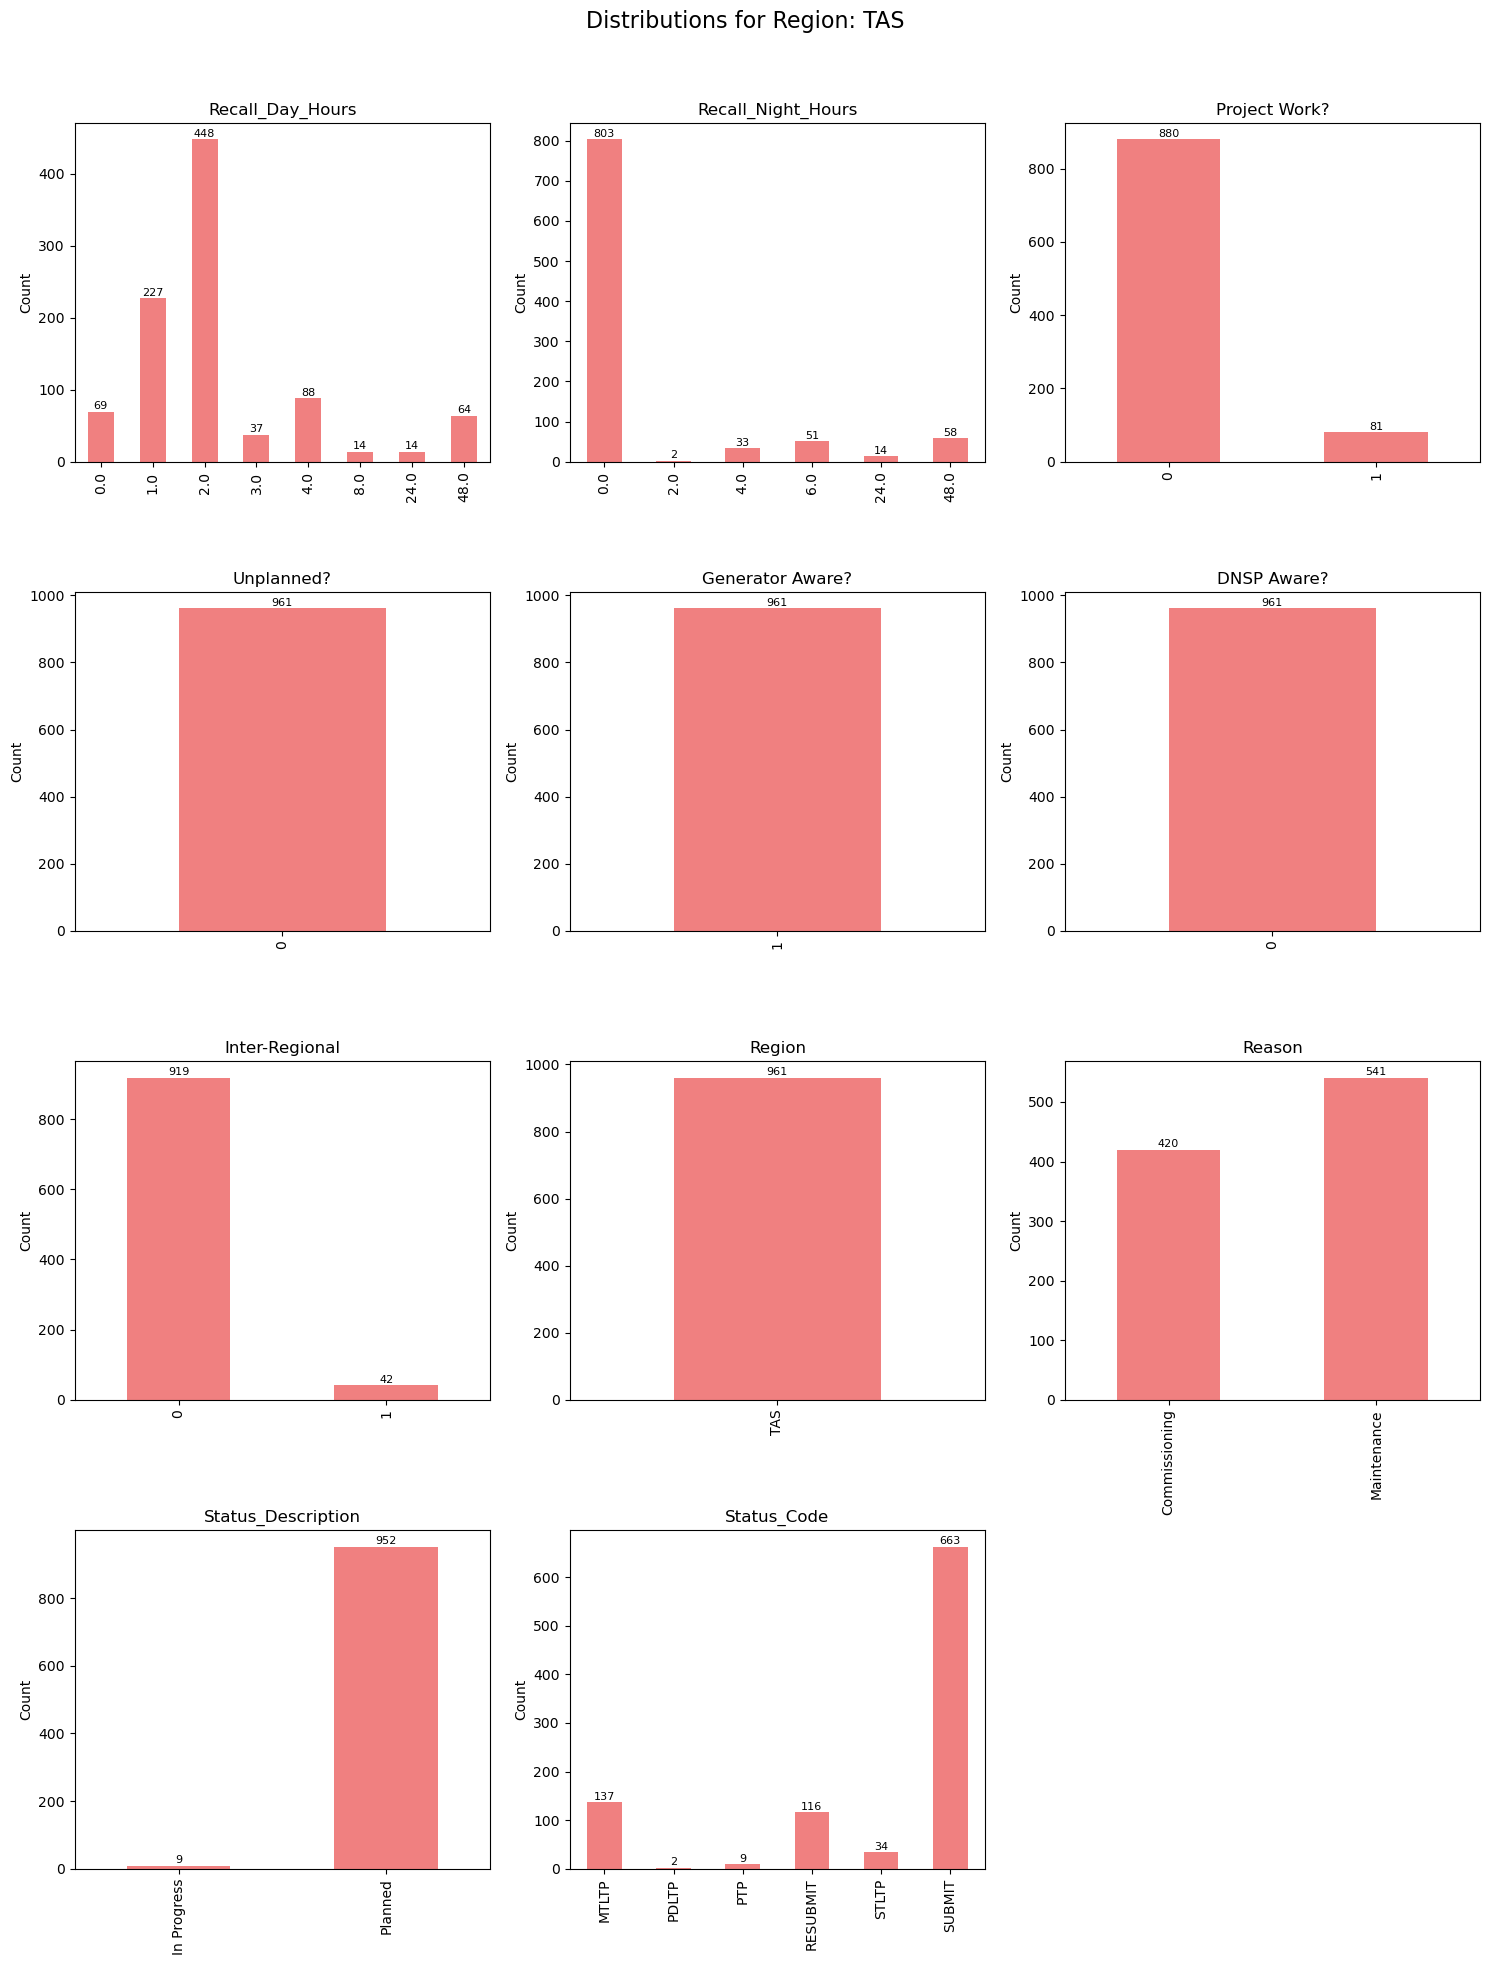

In [4]:
# visualisation for each region

regions = df['Region'].dropna().unique()
n_cols = 3

bool_cols = ['Project Work?', 'Unplanned?', 'Generator Aware?', 'DNSP Aware?', 'Inter-Regional']
numeric_cols = ['Recall_Day_Hours', 'Recall_Night_Hours']
categorical_cols = ['Region', 'Reason', 'Status_Description', 'Status_Code']

all_cols = numeric_cols + bool_cols + categorical_cols

for region in regions:
    region_df = df[df['Region'] == region]
    n_rows = (len(all_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axes = axes.flatten()
    fig.suptitle(f'Distributions for Region: {region}', fontsize=16)

    for idx, col in enumerate(all_cols):
        ax = axes[idx]
        counts = region_df[col].value_counts().sort_index()
        counts.plot(kind='bar', ax=ax, color='lightcoral')
        ax.set_title(col)
        ax.set_xlabel('')
        ax.set_ylabel('Count')

        for i, value in enumerate(counts):
            ax.text(i, value + 1, str(int(value)), ha='center', va='bottom', fontsize=8)

    for j in range(len(all_cols), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.96])  
    plt.show()

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## Perform regression for each state

In [7]:
from data.functions.regression_summary_and_plots import regression_summary_and_plots

In [8]:
# Loop through each unique region and assign a separate DataFrame
for region in df['Region'].unique():
    var_name = region.replace(" ", "_")  
    globals()[var_name] = df[df['Region'] == region].copy()


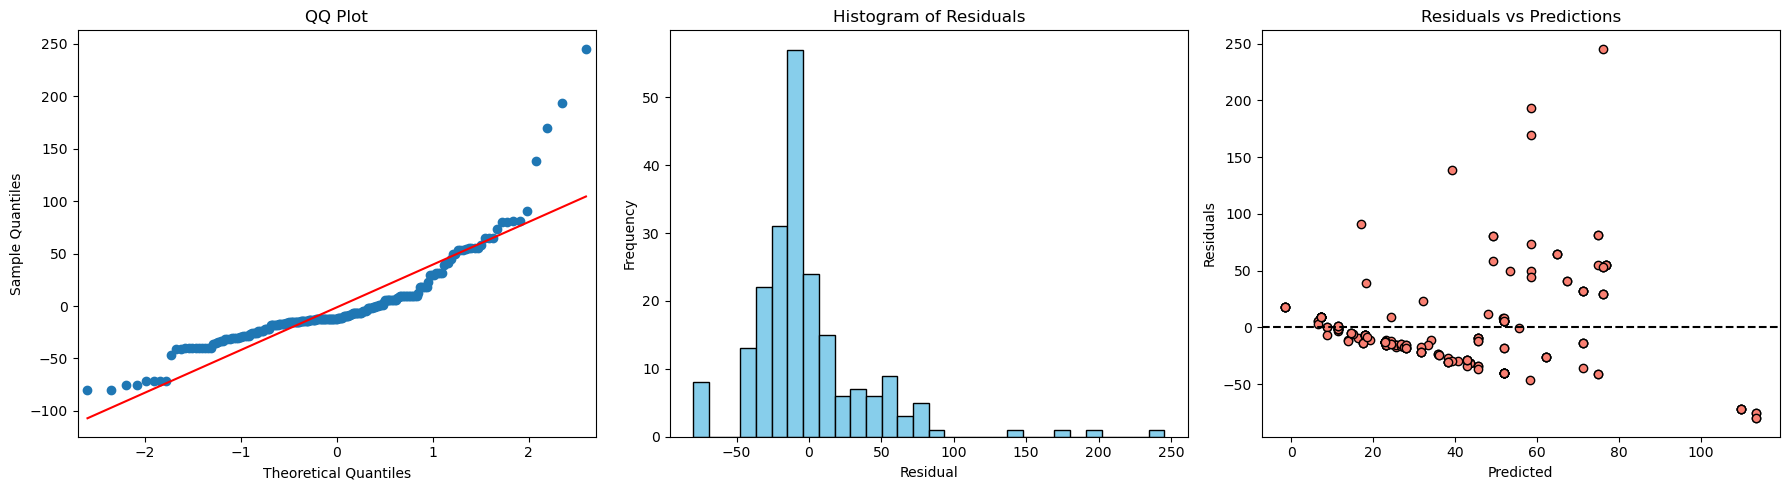

                            OLS Regression Results                            
Dep. Variable:         Duration_Hours   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     68.11
Date:                Fri, 16 May 2025   Prob (F-statistic):           5.54e-69
Time:                        22:19:24   Log-Likelihood:                -4360.0
No. Observations:                 842   AIC:                             8734.
Df Residuals:                     835   BIC:                             8767.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.5800      1.642     24.716      0.0

In [9]:
regression_summary_and_plots(NSW, 
                             ['Recall_Day_Hours', 'Recall_Night_Hours', 'Generator Aware?', 'DNSP Aware?', 'Inter-Regional', 'Reason'])

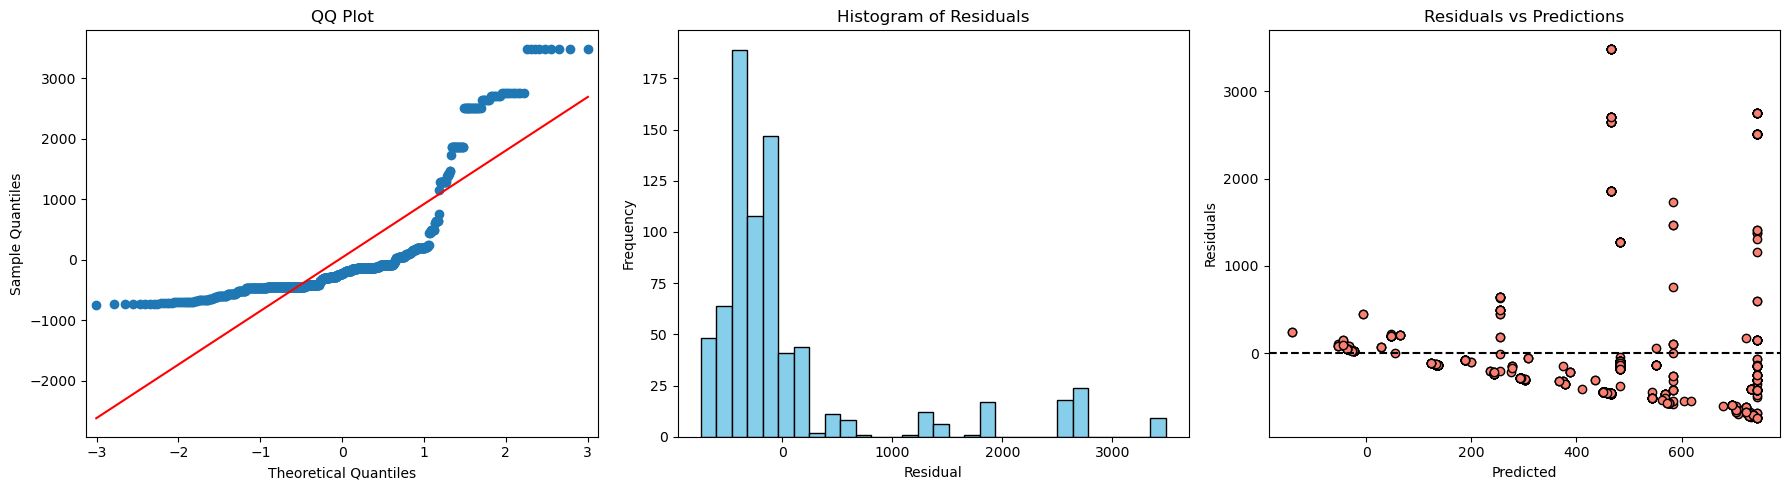

                            OLS Regression Results                            
Dep. Variable:         Duration_Hours   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     47.55
Date:                Fri, 16 May 2025   Prob (F-statistic):           1.85e-47
Time:                        22:19:24   Log-Likelihood:                -24452.
No. Observations:                3002   AIC:                         4.892e+04
Df Residuals:                    2996   BIC:                         4.895e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        557.2625     21.639     25.752      0.0

In [10]:
regression_summary_and_plots(QLD, 
                             ['Recall_Day_Hours', 'Recall_Night_Hours', 'Generator Aware?', 'DNSP Aware?', 'Reason'])

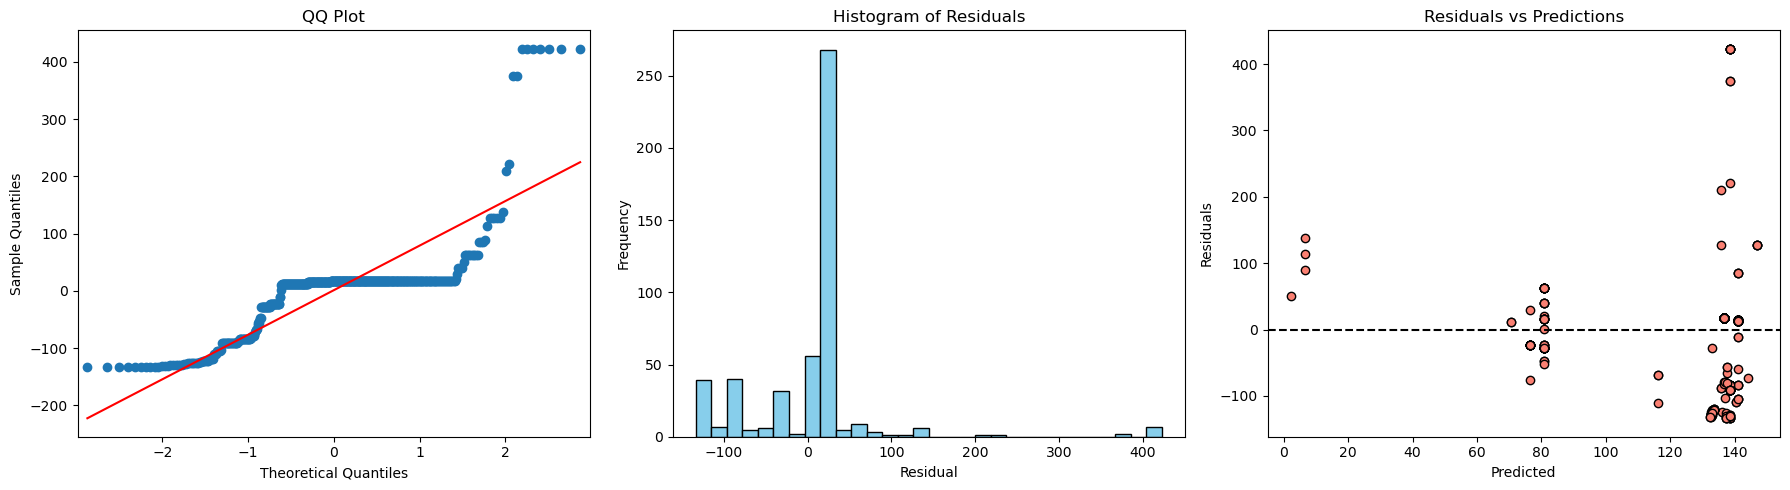

                            OLS Regression Results                            
Dep. Variable:         Duration_Hours   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     44.78
Date:                Fri, 16 May 2025   Prob (F-statistic):           5.08e-36
Time:                        22:19:25   Log-Likelihood:                -11244.
No. Observations:                1961   AIC:                         2.250e+04
Df Residuals:                    1956   BIC:                         2.253e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.3267     11.550      5.569      0.0

In [11]:
regression_summary_and_plots(SA, 
                             ['Recall_Day_Hours', 'Recall_Night_Hours', 'Inter-Regional', 'Reason'])

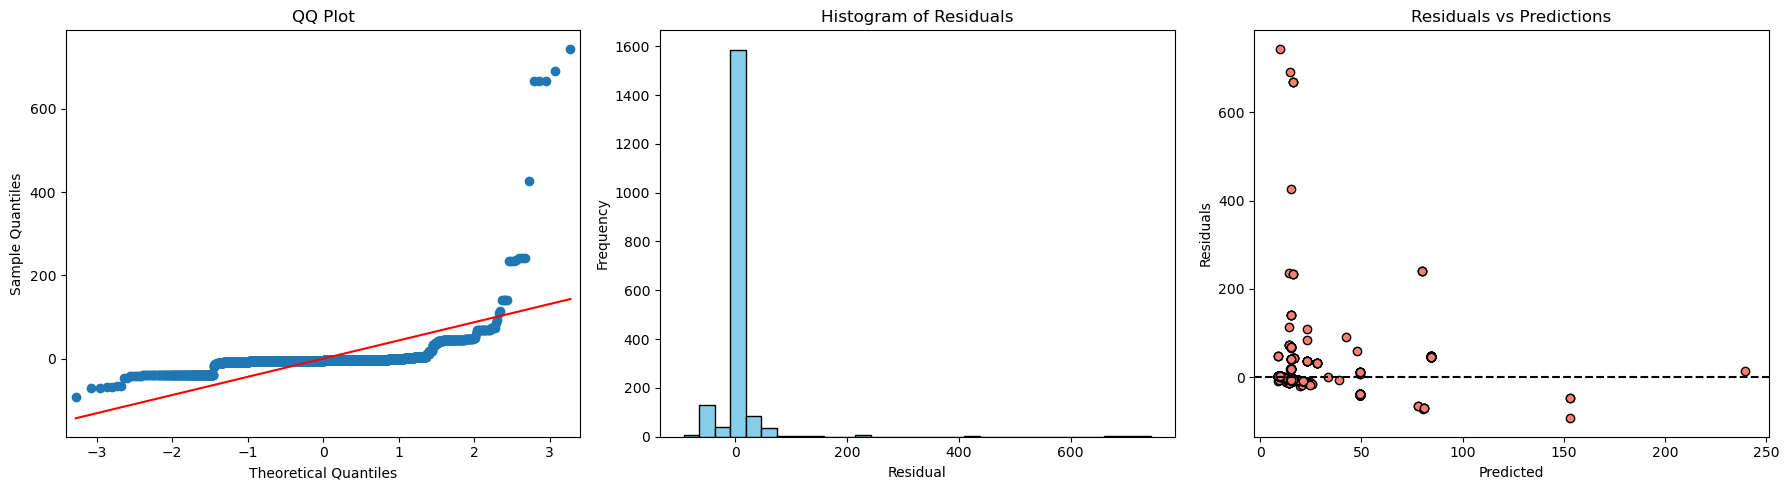

                            OLS Regression Results                            
Dep. Variable:         Duration_Hours   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     145.0
Date:                Fri, 16 May 2025   Prob (F-statistic):          1.89e-201
Time:                        22:19:25   Log-Likelihood:                -40379.
No. Observations:                7617   AIC:                         8.077e+04
Df Residuals:                    7609   BIC:                         8.083e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         86.2809      8.111     10.638      0.0

In [12]:
regression_summary_and_plots(VIC, 
                             ['Recall_Day_Hours', 'Recall_Night_Hours', 'Generator Aware?', 'DNSP Aware?', 'Inter-Regional', 'Reason'])

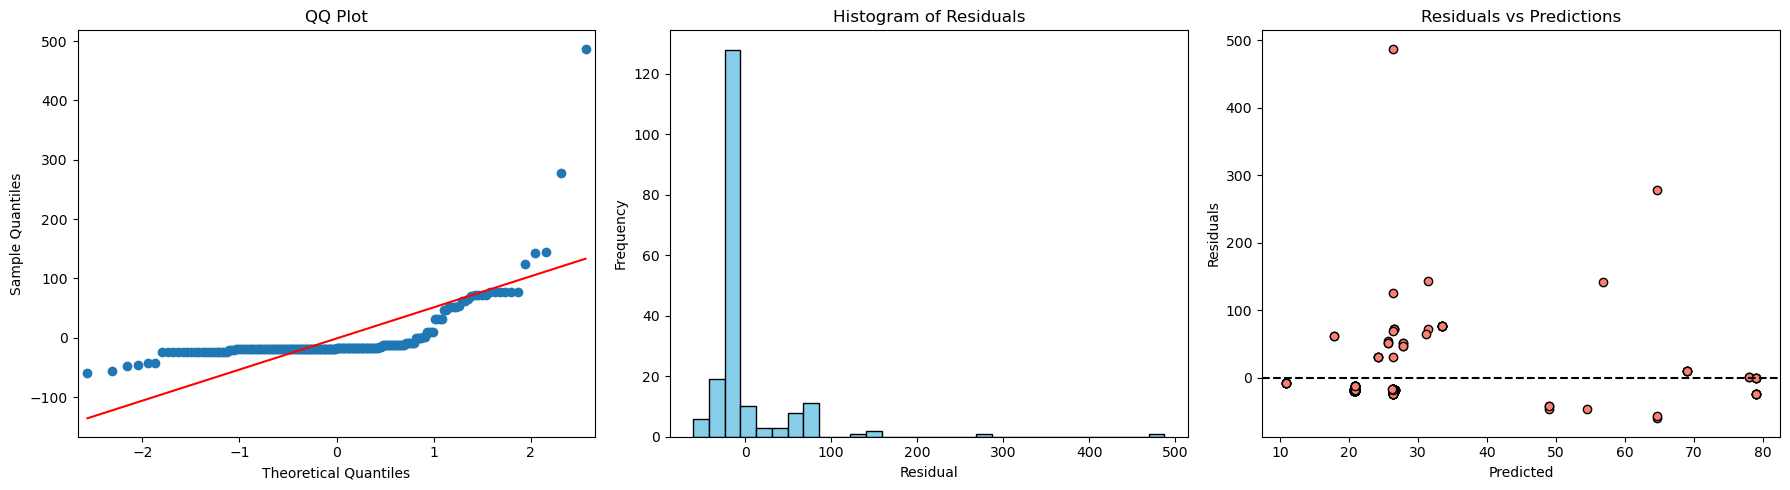

                            OLS Regression Results                            
Dep. Variable:         Duration_Hours   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.902
Date:                Fri, 16 May 2025   Prob (F-statistic):             0.0133
Time:                        22:19:25   Log-Likelihood:                -4681.6
No. Observations:                 768   AIC:                             9375.
Df Residuals:                     762   BIC:                             9403.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.1722      6.239      4.195      0.0

In [13]:
regression_summary_and_plots(TAS, 
                             ['Recall_Day_Hours', 'Recall_Night_Hours', 'Project Work?', 'Inter-Regional', 'Reason'])